In [1]:
import sys
import numpy as np
sys.path.append('..')
from Comms_System import Comms_System
from train_decision_making import train_DM_model
from DE_minibatch import DE
#from DE import DE
from objective_functions import MSE
from objective_functions import crossEntropy, crossEntropyPytorch
from Network import NeuralNetwork
import matplotlib.pyplot as plt
import scipy.stats
from ML_components import load_params

In [26]:
def get_data(num_symbols, sigma):
    
    symbol_set = [3, 1, -1, -3] # all symbols that we use
    symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
    m = 8
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)

    # calibrate
    gain_factor = np.max(CS.h)

    # upsample symbol sequence and filter it on transmission side
    upsampled = CS.upsample(v=False)
    Tx = np.convolve(upsampled, CS.h)

    # Transmit the filtered signal (i.e. add noise)
    Rx = Tx + np.random.normal(0.0, sigma, Tx.shape)  # add gaussian noise
    Rx_ = Rx/gain_factor

    blocks = CS.get_signal_in_blocks(Rx_)
    X = np.array(blocks)
    
    y = symbol_seq
    classes = np.array(symbol_set)
    num_classes = len(classes)
    sizes = [X.shape[1], 16, num_classes]

    # Makes a dictionary that maps a number to each symbol e.g. 3: 0
    class_idx = {v: i for i, v in enumerate(classes)}

    # Maps class indexes to each value in targets
    y = np.array([class_idx[v] for v in y])

    # Converts to one-hot-encoded
    y = np.eye(num_classes)[y]
    
    return X, y, classes, sizes

In [ ]:
w, b, sizes = load_params('../Weights/best_filtering_weights.npz', '../Weights/best_filtering_biases.npz')
start_agent = NeuralNetwork(sizes, startweights=w, startbiases=b, type='classification', afunc='relu')

In [29]:
Xtrain, ytrain, classes, sizes = get_data(num_symbols=100000, sigma=1)
Xtest, ytest, _, _ = get_data(num_symbols=100000, sigma=1)

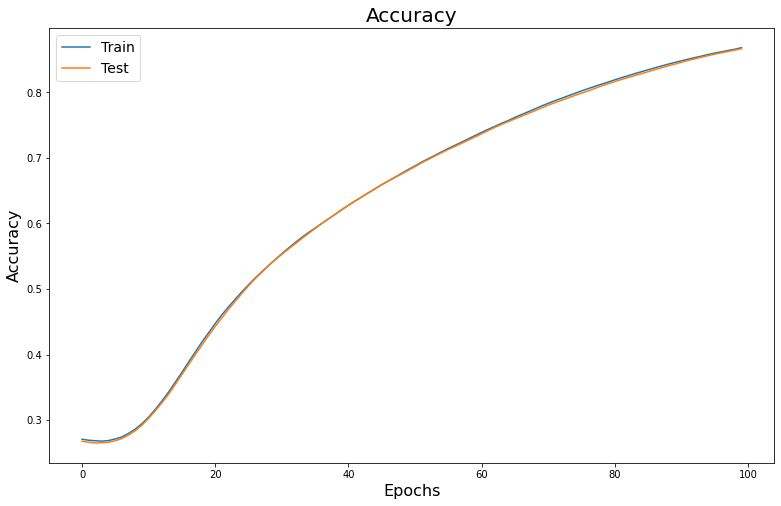

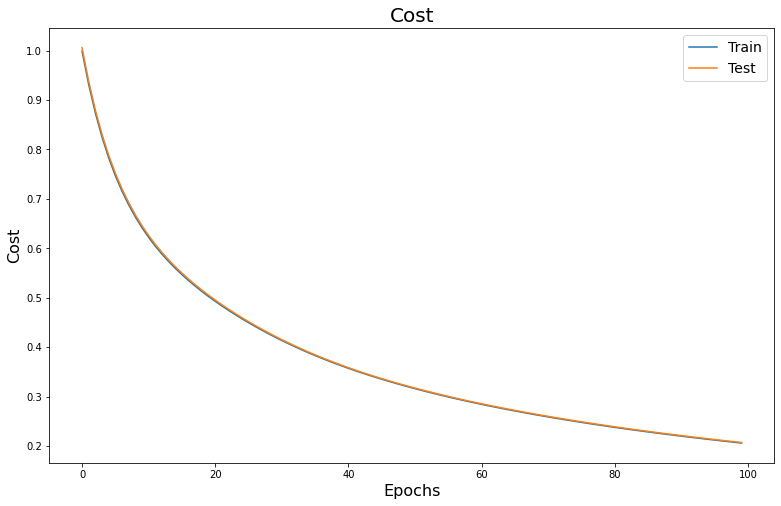

In [30]:
optimizer = 'BP'
early_stop = True

if optimizer == 'DE':
    D = DE(objective_function=crossEntropy, sizes=sizes, pop_size=50, F=0.55, cr=0.85,
           X=Xtrain, y=ytrain, Xtest=Xtest, ytest=ytest, type='classification', afunc='relu')
    
    if early_stop: 
        best_agent, opt_agent = D.early_stop_training(patience=200, batch_size=Xtrain.shape[0]//3, measure='accuracy')
    else:
        best_agent = D.evolution(num_epochs=5001, batch_size=Xtrain.shape[0], verbose=True, print_epoch=100)
        D.evaluate()
    
elif optimizer == 'BP':
    NN = NeuralNetwork(sizes=sizes, afunc='relu')
    NN.train_loop(Xtrain, ytrain, Xtest, ytest, epochs=100, batch_size=Xtrain.shape[0]//3, 
                  cost=True, acc=True, plot=True)
    best_agent = NN

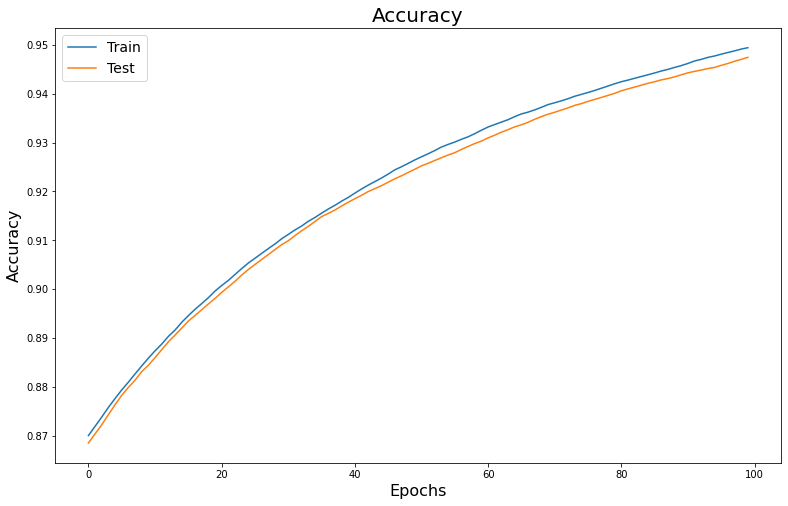

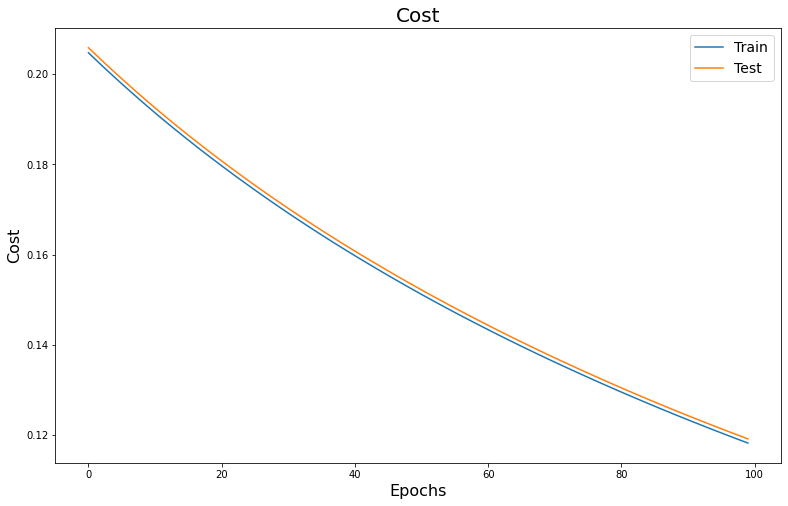

(array([0.21, 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.19, 0.19,
        0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.18, 0.18, 0.18, 0.18, 0.18,
        0.18, 0.18, 0.18, 0.18, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17,
        0.17, 0.17, 0.17, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
        0.16, 0.16, 0.16, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
        0.15, 0.15, 0.15, 0.15, 0.15, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14,
        0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.13, 0.13, 0.13,
        0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13,
        0.13, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12,
        0.12]),
 array([0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.19, 0.19, 0.19,
        0.19, 0.19, 0.19, 0.19, 0.19, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18,
        0.18, 0.18, 0.18, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17,
        0.17, 0.17, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
        0.16, 0.16, 0.

In [33]:
NN.train_loop(Xtrain, ytrain, Xtest, ytest, epochs=100, batch_size=Xtrain.shape[0]//3, 
                  cost=True, acc=True, plot=True)

In [ ]:
best_agent, opt_agent = D.early_stop_training(patience=300, batch_size=Xtrain.shape[0]//3, measure='accuracy')

In [31]:
# Get predictions
predictions = D.opt_agent.feedforward(Xtest).argmax(axis=1)
true = ytest.argmax(axis=1)

# Convert back to symbols
predicted_symbols = classes[predictions]
true_values = classes[true]
# print(predicted_symbols, true_values)
correct_preds = np.equal(true_values, predicted_symbols)
print("Accuracy: ", (sum(correct_preds) / len(true_values)) * 100, "%")

Accuracy:  99.546 %


In [ ]:
start_agent.feedforward(Xtrain)

In [32]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 100000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m)
noise_level = 1

# Automatic test
euclid_decisions, NN_decisions, block_decisions, filter_decisions, _ = CS.test_CS(noise_level=noise_level,
                                                                                 filter_model=D.opt_agent)
print('Euclidean Distance Error Rate: {}%'.format((CS.evaluate(euclid_decisions)[1]*100).round(2)))
#print('NN Decision Making Error Rate: {}%'.format((CS.evaluate(NN_decisions)[1]*100).round(2)))
#print('NN Block Error Rate: {}%'.format((CS.evaluate(block_decisions)[1]*100).round(2)))
print('NN Filter Error Rate: {}%'.format((CS.evaluate(filter_decisions)[1]*100).round(2)))
print()

Euclidean Distance Error Rate: 0.35%
NN Filter Error Rate: 0.47%

